In [1]:
%cd ..

/home/antonbabenko/Projects/newsclass01


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer

%config InlineBackend.figure_format = 'retina' 

In [4]:
random_state = 42

In [5]:
data_dir = Path("data")
folds_dir = Path("folds")
train_path = data_dir / "train.csv"

In [6]:
df = pd.read_csv(train_path, index_col="Id")

In [10]:
df.head()

,title,text,images,source
Id,,,,
1,Міністри Зеленського лишають мільйони пацієнті...,Міністри Зеленського лишають мільйони пацієнті...,NaN,5
2,В АМКУ звертаються щодо незаконної державної д...,В АМКУ звертаються щодо незаконної державної д...,fd92a3dd-1109-49d8-8f5f-eeed72da22ef.png,6
5,У Польщі виявили майже 16 тисяч нових хворих н...,У Польщі виявили майже 16 тисяч нових хворих н...,f4a284d0-9bb7-4910-8a62-a7bfd0ec29b6.png,2
9,Закриття міжбанку: гривня трохи ослабла,Закриття міжбанку: гривня трохи ослабла 2 жовт...,NaN,3
10,"У Москві помер український шахіст із бази ""Мир...","У Москві помер український шахіст із бази ""Мир...","2cbb2339-6dd2-4000-a53c-225ec7aad892.png,d5233...",0


In [8]:
df.text = df.title + " " + df.text

## Initial distribution

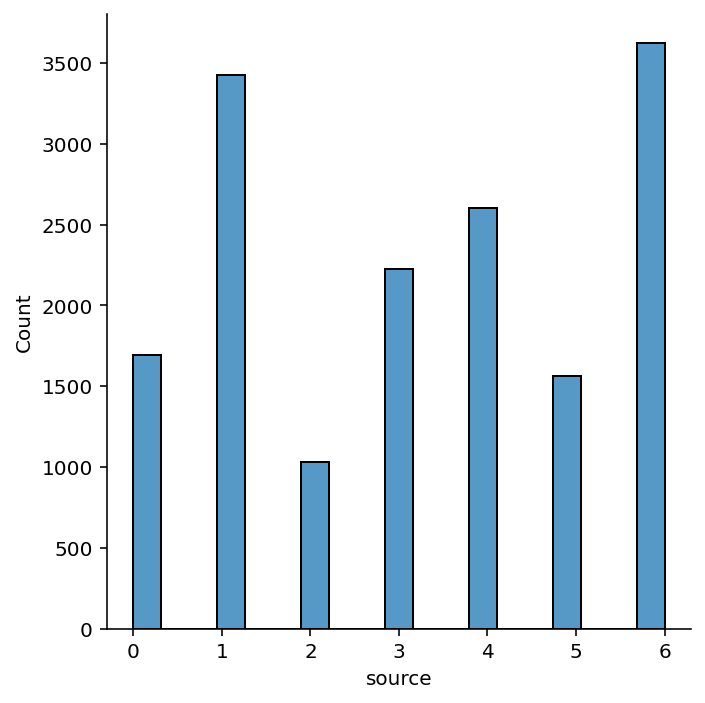

In [11]:
sns.displot(df["source"])

## Stratify

In [12]:
kfold = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)  

In [13]:
target_values = df[["source"]]
# est = KBinsDiscretizer(n_bins=50, encode='nominal', strategy='quantile')
# stratify_on = est.fit_transform(target_values).T[0]
splits = kfold.split(df, target_values)

In [14]:
splits

<generator object _BaseKFold.split at 0x7f08ddac8660>

In [15]:
folds = []
for _, test_indexes in splits:
    folds.append(df.iloc[test_indexes])

6


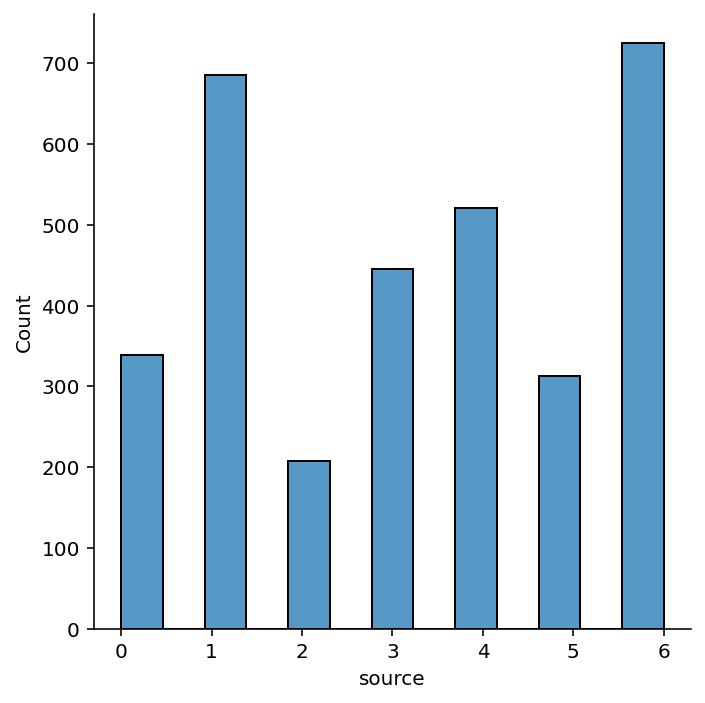

6


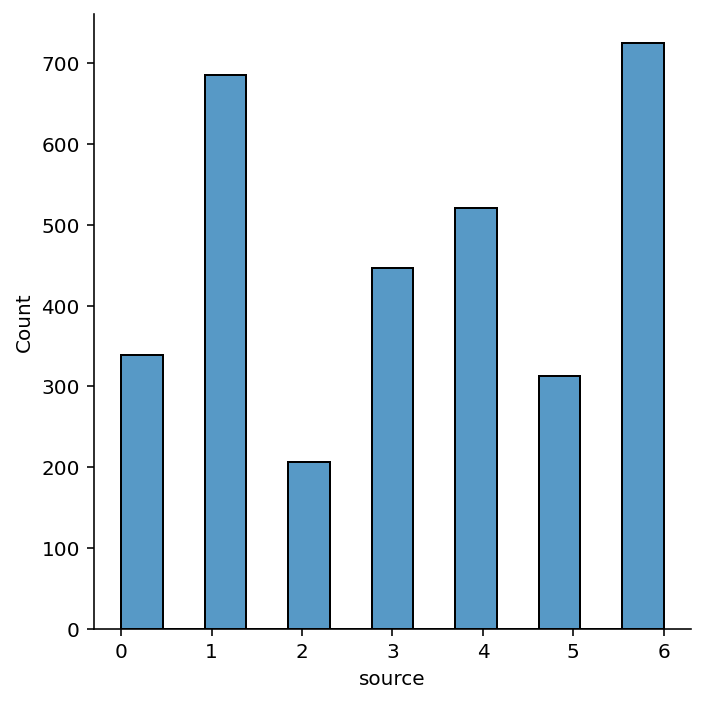

6


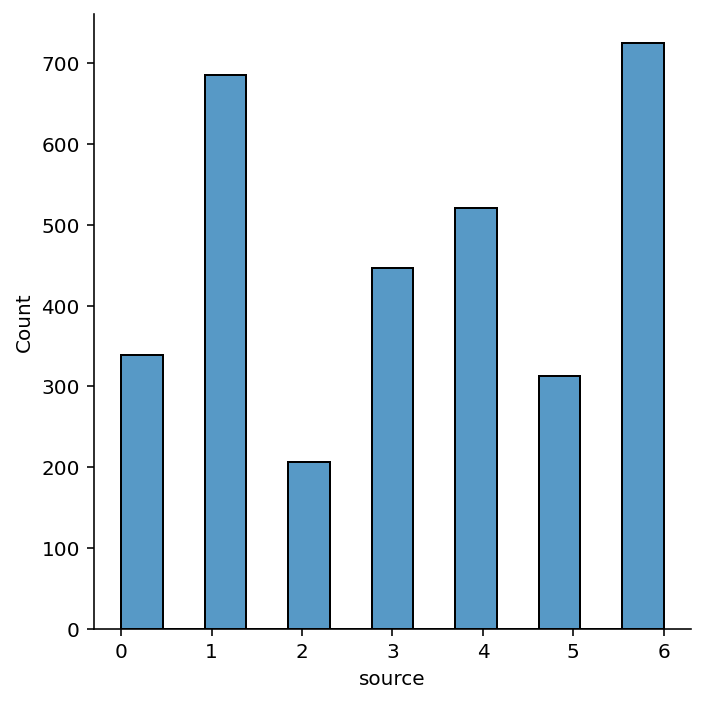

6


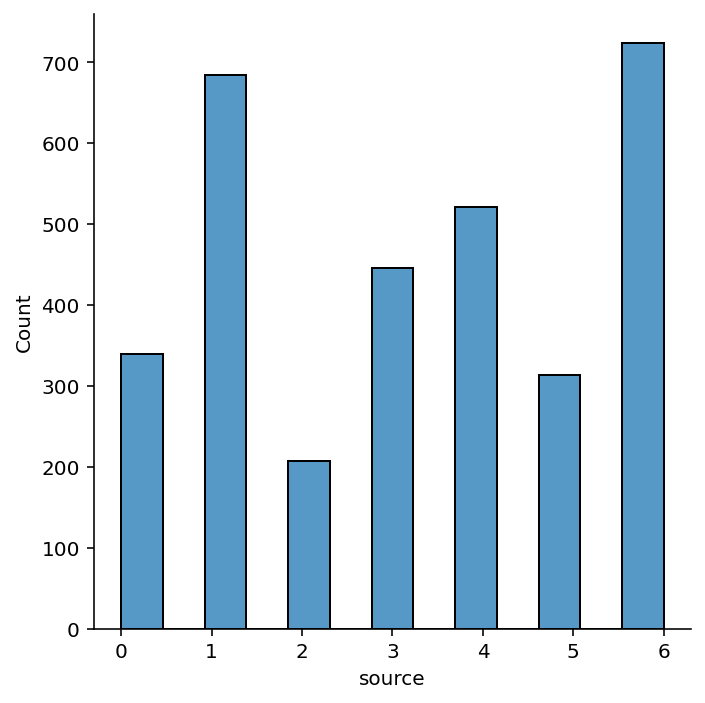

6


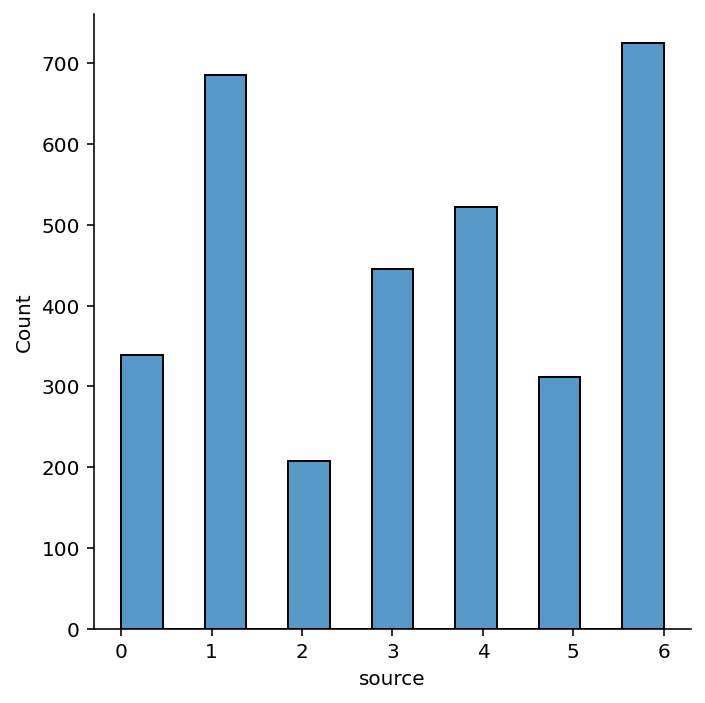

In [16]:
for fold in folds:
    print(max(fold["source"]))
    sns.displot(fold["source"])
    plt.show()

## Post balancing

In [17]:
def upsample(fold, max_value):
    print(fold.shape)
    for label in fold.source.unique():
        values_to_add = max_value - fold[fold.source == label].shape[0]
        
        additional_fold_data = pd.DataFrame()
        
        while values_to_add > 0:
            for i in range(fold.shape[0]):
                if values_to_add == 0:
                    break

                if fold.iloc[i]["source"] == label:
                    additional_fold_data = additional_fold_data.append(fold.iloc[i])
                    values_to_add -= 1
        fold = fold.append(additional_fold_data)
    print(fold.shape)
    return fold

In [18]:
np.max(folds[0].source.value_counts().values)

725

In [19]:
b_folds = []
for fold in folds:
    b_folds.append(upsample(fold, np.max(fold.source.value_counts().values)))

(3236, 4)
(5075, 4)
(3236, 4)
(5075, 4)
(3235, 4)
(5075, 4)
(3235, 4)
(5068, 4)
(3235, 4)
(5075, 4)


In [20]:
folds = b_folds

6.0


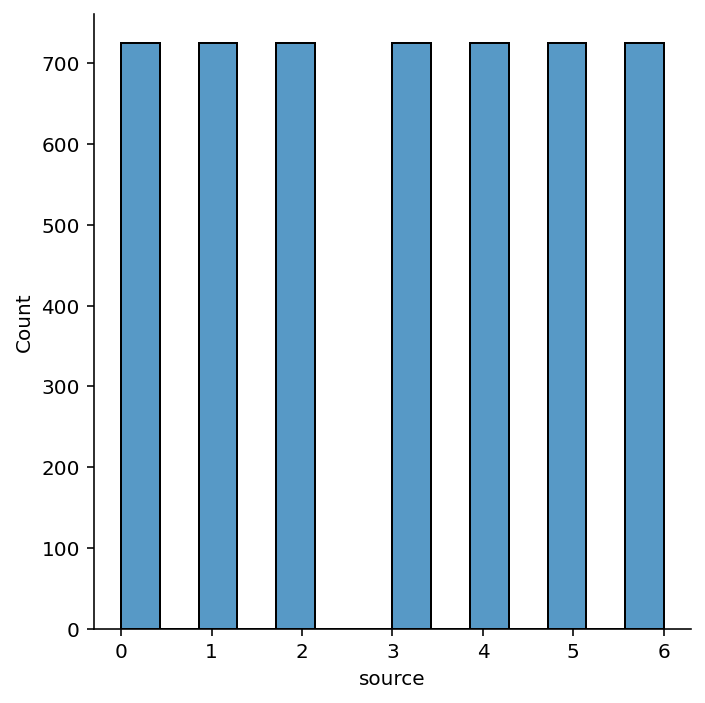

6.0


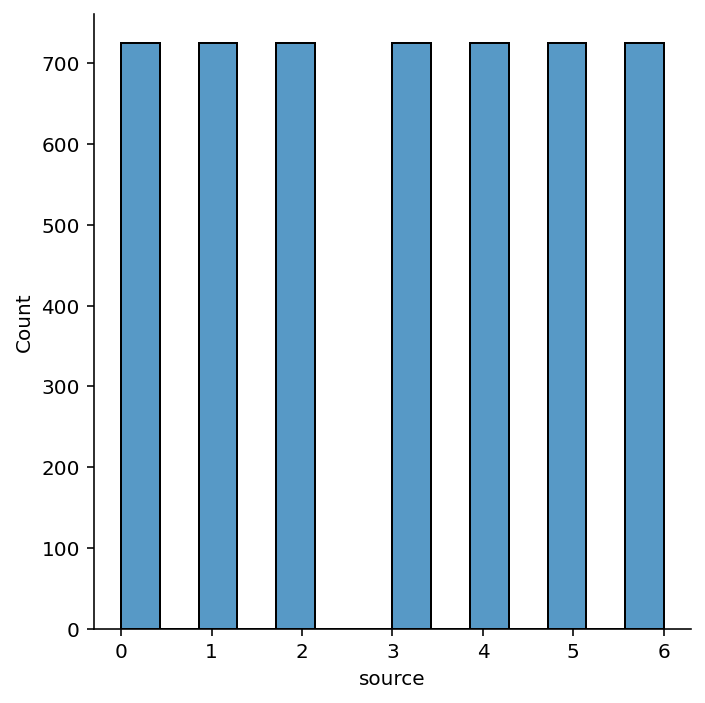

6.0


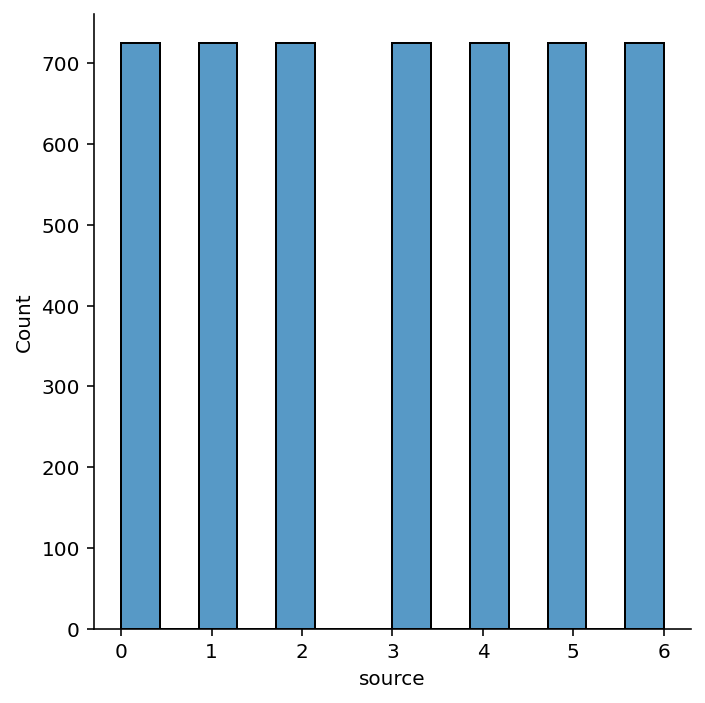

6.0


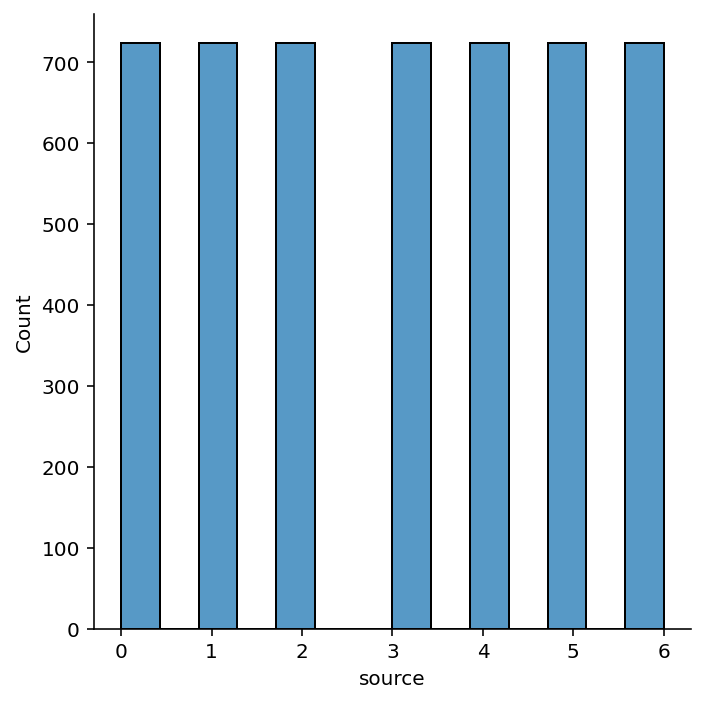

6.0


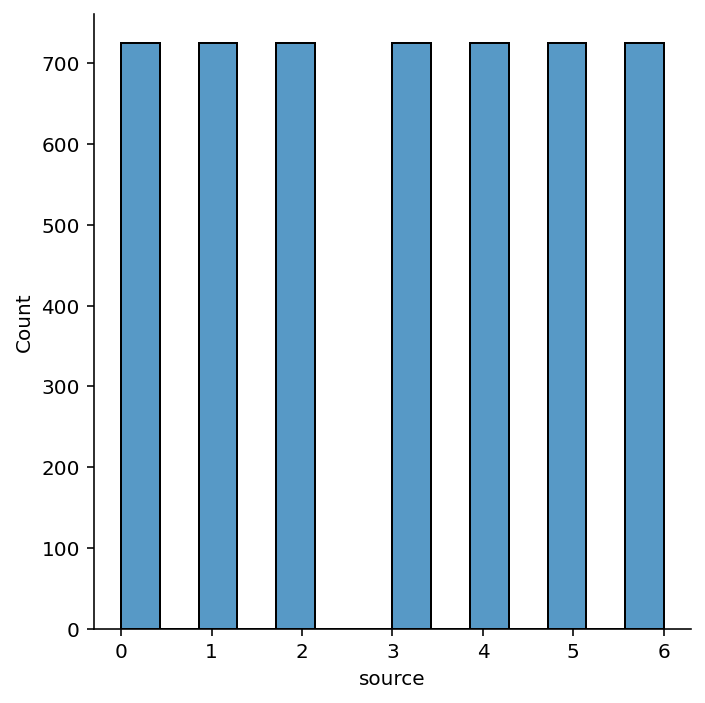

In [21]:
for fold in folds:
    print(max(fold["source"]))
    sns.displot(fold["source"])
    plt.show()

In [22]:
for i, fold in enumerate(folds):
    fold.to_csv(folds_dir / f"fold_{i}.csv", index=False)